In [3]:
import os
import sys #current as of 9/26/2015
spark_home = os.environ['SPARK_HOME'] = \
   '/opt/spark16'
    
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.1
      /_/

Using Python version 2.7.10 (default, Oct 23 2015 18:05:06)
SparkContext available as sc, SQLContext available as sqlContext.


In [8]:
import numpy as np
from numpy.random import rand
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pylab

from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint

%matplotlib inline

>### HW11.0  
>What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.

>Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes.



The core difference between broadcasting and caching is that the use of caching is meant for static data, such as training examples, which doesn't need to change across each iteration of the algorithm, whereas broadcasted data can change during each iteration. 

For example, during logistic regression the weight vector would be broadcasted RDDs to each executor once for each iteration instead of once for each block of data AND each iteration. Below is an example of broadcast in code:
<code>
for i in range(iterations):  
    weights_broadcast = sc.broadcast(weights)  
    gradient = data\
                .map(lambda p: partial_gradient(p, weights_broadcast))\
                .reduce(lambda a,b: a+b)  
</code>

In the above example, the broadcasted weights would be used to create a new gradient, which would be used during the calculation of a new weight vector. 

Caching would be used any time data is read to an RDD and needs to frequently be referenced, but will not need to change during each iteration, for example. A good example of the need for caching would be reading in training data, which is accessed frequently but doesn't change. Here is what caching would look like in code:
<code>
data = sc.textFile('somedata.txt').map(readPoint).cache()
</code>




In [5]:
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

Iteration0
[[ 1.10117173  0.2369475 ]
 [ 3.9922882   2.66319924]
 [ 2.01485884  5.6843352 ]]


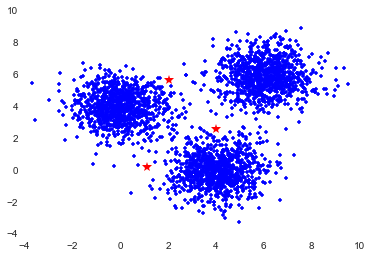

Iteration1
[[ 2.1764096   0.47605573]
 [ 5.40891051  2.94145855]
 [ 1.91146097  5.20342786]]


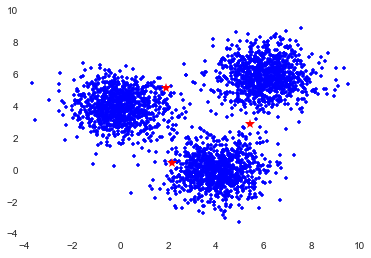

Iteration2
[[ 3.41825109  0.03993785]
 [ 6.09321675  4.91837636]
 [ 0.68646836  4.56821496]]


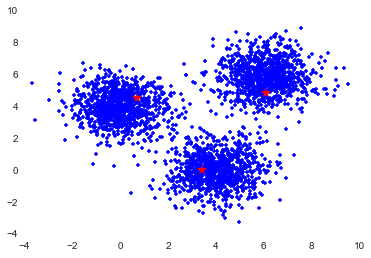

Iteration3
[[  3.99116559e+00   6.53600243e-03]
 [  6.07197455e+00   5.89870342e+00]
 [  4.45680388e-03   4.03585510e+00]]


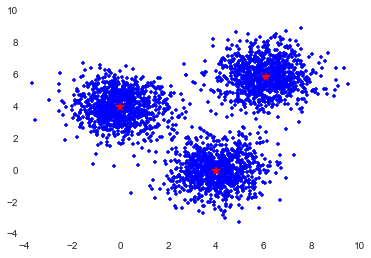

Iteration4
[[  4.02691092e+00   1.88083916e-02]
 [  6.06048975e+00   5.93491670e+00]
 [ -1.49860775e-03   4.00856550e+00]]


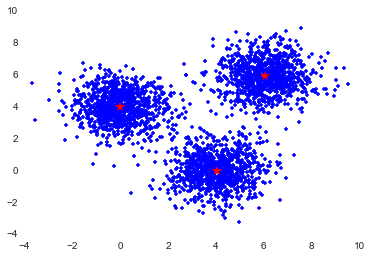

Final Results:
[[  4.02691092e+00   1.88083916e-02]
 [  6.06048975e+00   5.93491670e+00]
 [ -1.49860775e-03   4.00856550e+00]]


In [15]:
#Calculate which class each data point belongs to
def nearest_centroid(line, c):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - c.value)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()
    
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):  
    cBcast = sc.broadcast(centroids)
    res = D.map(lambda x: nearest_centroid(x, cBcast)).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    res = sorted(res, key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-cBcast.value))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results:"
print centroids

> ### HW 11.3
>Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.

>def generateData(n):  
 """  
  generates a 2D linearly separable dataset with n samples.  
  The third element of the sample is the label  
 """  
 xb = (rand(n)*2-1)/2-0.5  
 yb = (rand(n)*2-1)/2+0.5  
 xr = (rand(n)*2-1)/2+0.5  
 yr = (rand(n)*2-1)/2-0.5  
 inputs = []  
 for i in range(len(xb)):  
  inputs.append([xb[i],yb[i],1])  
  inputs.append([xr[i],yr[i],-1])  
 return inputs  

>Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

>NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

>Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words. 

>Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm . 

>Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

>weight(X)= 1/||X||, 

>where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

>Here X is vector made up of X1 and X2.

>Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.

>Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set. 

In [16]:
def generateData(n):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    xb = (rand(n)*2-1)/2-0.5
    yb = (rand(n)*2-1)/2+0.5
    xr = (rand(n)*2-1)/2+0.5
    yr = (rand(n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

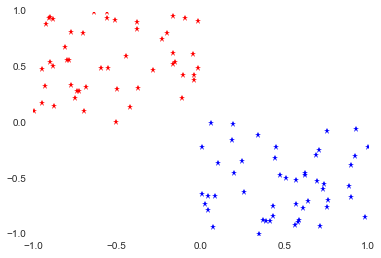

In [70]:
d = np.array(generateData(50))
d1 = d[d[:,2]==1]
d2 = d[d[:,2]==-1]
plt.plot(d1[:,0],d1[:,1],'r*', d2[:,0],d2[:,1],'b*')

In [9]:
def generateNonsepData(n):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    xb = (rand(n)*2-1)/2-0.4
    yb = (rand(n)*2-1)/2+0.4
    xr = (rand(n)*2-1)/2+0.4
    yr = (rand(n)*2-1)/2-0.4
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

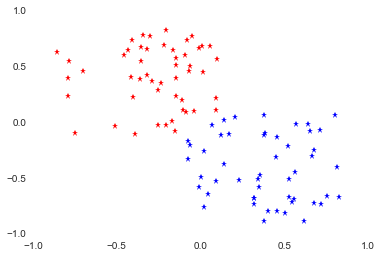

In [203]:
d = np.array(generateNonsepData(50))
d1 = d[d[:,2]==1]
d2 = d[d[:,2]==-1]
plt.plot(d1[:,0],d1[:,1],'r*', d2[:,0],d2[:,1],'b*')

#### run MLlib logistic regression 

In [7]:
@np.vectorize
def binarize(x):
    return int(x>0)

def format_data(x, labels, p=2):
    data = []
    for i in xrange(x.shape[0]):
        data.append(LabeledPoint(binarize(labels[i]),x[i,:]))
    return sc.parallelize(data, p)

In [478]:
def test_iterations(N, iterations=10, datafunc=generateNonsepData ):
    d = np.array(datafunc(N))
    train = d[:N*.8]
    test = d[N*.2:]
    data = format_data(train[:,:2],train[:,2],10)
    lm = LogisticRegressionWithSGD.train( data
                                        , iterations=iterations
                                        , initialWeights=np.array([1.0,1.0])
                                        , regType='l1')
    predictions = []
    for x in test:
        predictions.append(lm.predict(x[:2]))
    actuals = binarize(test[:,2])
    accuracy = np.mean([ p==a for p,a in zip(predictions, actuals) ])
    return accuracy

In [479]:
results = []
for i in xrange(10):
    results.append(test_iterations(1000, i+1))

#### The ideal number of iterations appears to be around 30

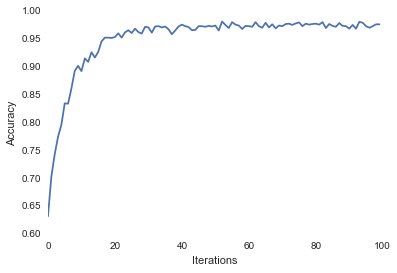

In [473]:
plt.plot(range(len(results)),results)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

#### homegrown weighted-LASSO LR 

In [22]:
def pgradient(p, w):
    y = 1 if p.label == 1 else -1
    weighted = 1 / np.linalg.norm(p.features)
    return weighted*(1/ (1+np.exp(-y*np.dot(w.value,p.features)))-1) \
                            * y * np.array(p.features)

def is_converged(w_old, w_new, threshold):
    diff = w_old - w_new
    return np.linalg.norm(diff) < threshold * np.max([np.linalg.norm(w_new), 1.0])

class LogisticRegressionLassoHG(object):
    def __init__(self, weights):
        self.weights = weights
    
    @staticmethod
    def train(data \
              , weightsInitial=None \
              , learningRate=0.05 \
              , iterations=10 \
              , regParam=0.01 \
              , tol=0.001):
        
        featureLen = len(data.take(1)[0].features)
        n = data.count()

        if not weightsInitial:
            w = np.random.normal(size=featureLen)
        else:
            w = np.array(weightsInitial)

        for i in xrange(iterations):
            wBcast = sc.broadcast(w)
            gradient = data.map(lambda p: pgradient(p, wBcast)).reduce(lambda a,b: a+b)
            wReg = w * 1 
            wReg[-1] = 0
            wReg = np.sign(wReg)
            gradient = gradient + regParam * wReg
            w_new = w - (learningRate * gradient / n)
            if is_converged(w, w_new, tol):
                w = w_new
                break
            w = w_new
        
        return LogisticRegressionLassoHG(w)
    
    def predict(self, x):
        p = 1 / (1+np.exp(-np.dot(self.weights,np.array(x))))
        if p>0.5: return 1
        else: return 0

In [31]:
def test_iterations(N, iterations=10, datafunc=generateNonsepData ):
    d = np.array(datafunc(N))
    train = d[:N*.8]
    test = d[N*.2:]
    data = format_data(train[:,:2],train[:,2],10)
    lm = LogisticRegressionLassoHG.train(   data \
                                           , weightsInitial=[1,1]
                                           , iterations=iterations )
    predictions = []
    for x in test:
        predictions.append(lm.predict(x[:2]))
    actuals = binarize(test[:,2])
    misclass = 1 - np.mean([ p==a for p,a in zip(predictions, actuals) ])
    return misclass

In [32]:
results = []
for i in xrange(100):
    results.append(test_iterations(1000, i+1))

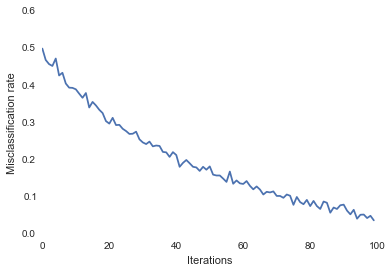

In [33]:
plt.plot(range(len(results)),results)
plt.xlabel('Iterations')
plt.ylabel('Misclassification rate')